<a href="https://colab.research.google.com/github/Deepsaha07/PPG_Analysis/blob/master/PPG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler
#np.set_printoptions(threshold=sys.maxsize)
from keras.models import Sequential
from scipy import signal
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.preprocessing import sequence
import scipy.io as scio
# fix random seed for reproducibility
np.random.seed(7)
import math
import warnings

warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import sys
from sklearn.preprocessing import StandardScaler
#np.set_printoptions(threshold=sys.maxsize)
from keras.models import Sequential
from numba import jit,cuda
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.preprocessing import sequence
import scipy.io as scio
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
np.random.seed(7)
import warnings
warnings.filterwarnings('ignore')

Loading from google drive in Colab only

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Loading from Local Drive in form of Dictionary

In [4]:
import os
import pandas as pd

print(os.getcwd())
#path = '/content/gdrive/MyDrive/csv'
path ='D:\GitHub\PPG_Analysis\csv'
set = {}


for dataset in os.listdir(path):

    head,sep,tail = dataset.partition('.')   #Taking the head as subject name
     #print(head)
    data = pd.read_csv(os.path.join(path,dataset))
    set[head] = data                         # Saving data against individual subject name in dictionary format


D:\GitHub\PPG_Analysis


In [5]:
# So it will look like this

print(set)

{'s10_run':                               time    ecg  peaks  pleth_1  pleth_2  pleth_3  \
0       2021-01-01 11:22:48.305804  33664      0    65589    69333     3164   
1       2021-01-01 11:22:48.307804  33866      0    65589    69333     3164   
2       2021-01-01 11:22:48.309804  34155      0    65595    69334     3181   
3       2021-01-01 11:22:48.311804  34366      0    65591    69349     3175   
4       2021-01-01 11:22:48.313804  34538      0    65583    69343     3186   
...                            ...    ...    ...      ...      ...      ...   
242810  2021-01-01 11:30:53.925806  31926      0    64310    64964     3313   
242811  2021-01-01 11:30:53.927806  32012      0    64310    64964     3313   
242812  2021-01-01 11:30:53.929806  32322      0    64298    64925     3312   
242813  2021-01-01 11:30:53.931806  32788      0    64266    64885     3309   
242814  2021-01-01 11:30:53.933806  33205      0    64251    64835     3303   

        pleth_4  pleth_5  pleth_6     l

If we observe the keys of the dictionary, we can see that there are total 22 subjects, each performing 3 different activites.

In [7]:
set.keys()

dict_keys(['s10_run', 's10_sit', 's10_walk', 's11_run', 's11_sit', 's11_walk', 's12_run', 's12_sit', 's12_walk', 's13_run', 's13_sit', 's13_walk', 's14_run', 's14_sit', 's14_walk', 's15_run', 's15_sit', 's15_walk', 's16_run', 's16_sit', 's16_walk', 's17_run', 's17_sit', 's17_walk', 's18_run', 's18_sit', 's18_walk', 's19_run', 's19_sit', 's19_walk', 's1_run', 's1_sit', 's1_walk', 's20_run', 's20_sit', 's20_walk', 's21_run', 's21_sit', 's21_walk', 's22_run', 's22_sit', 's22_walk', 's2_run', 's2_sit', 's2_walk', 's3_run', 's3_sit', 's3_walk', 's4_run', 's4_sit', 's4_walk', 's5_run', 's5_sit', 's5_walk', 's6_run', 's6_sit', 's6_walk', 's7_run', 's7_sit', 's7_walk', 's8_run', 's8_sit', 's8_walk', 's9_run', 's9_sit', 's9_walk'])

So this dictioanry is now comprised of the data for different activities performed by different subjects, for example s10_run means the PPG dataset of Subject 10, while running.

Now if we see the different physiological signal taken from the subjects there are total 18. 
But for our analysis, we will only take first 8 signal data, which are ECG, Peaks, and Pleth 1 to Pleth 6. These will be used as features.

In the next step, we are converting this dictionary data into a dataframe matrix set. Where the subject serial numbers will be subject id, and the activity will be considered as label.

For example, 's7_sit' will go like 'SubjectID' : s7, 'Label' : 'sit'

In [9]:

alllabels = pd.DataFrame()
dset = pd.DataFrame()
i=0
for key,value in set.items():
    
    subs=[]
    labels = []
    featureset=[]
    data = pd.DataFrame(value.iloc[:,:9])
    sub_label = key.split('_')
    sub = sub_label[0]
    label = sub_label[1]
    
    for i in range(len(data)):
        subs.append([sub])
        labels.append(label)
    labels = pd.DataFrame(labels,columns=['Label'])
    subs = pd.DataFrame(subs,columns=['SubjectID'])
    featureset = pd.concat([subs,data,labels],axis=1)
    if i<1:
        dset = featureset
        
    else:
        
        f = featureset.copy()
        
        dset = pd.concat([dset,f],axis=0)
       
    i+=1
    

So the data set will look like

In [10]:
print(dset.head(5))

  SubjectID                        time    ecg  peaks  pleth_1  pleth_2  \
0       s10  2021-01-01 11:22:48.305804  33664      0    65589    69333   
1       s10  2021-01-01 11:22:48.307804  33866      0    65589    69333   
2       s10  2021-01-01 11:22:48.309804  34155      0    65595    69334   
3       s10  2021-01-01 11:22:48.311804  34366      0    65591    69349   
4       s10  2021-01-01 11:22:48.313804  34538      0    65583    69343   

   pleth_3  pleth_4  pleth_5  pleth_6 Label  
0     3164    90553   103093     5652   run  
1     3164    90558   103077     5647   run  
2     3181    90544   103098     5660   run  
3     3175    90544   103098     5660   run  
4     3186    90554   103093     5651   run  


As the time data is irrelevent we are going to drop that column

In [12]:
dset=dset.drop(['time'],axis=1)

Now, the feature set will only be the dataset, excluding subject id and label data. 

In [13]:
features = dset.drop(['SubjectID','Label'],axis =1)
featureshape = features.shape[1]

Now we will group the dataset by their subject ID which will be the dataset gp.
Later we have to group by their label too. So for that, forgrouping dataset will be used, which will have the feature set along with the labels.

In [14]:

gp=dset.groupby('SubjectID').agg(pd.Series.tolist)
forgrouping = dset.drop(['SubjectID'],axis=1)
forgroupingcolumns = forgrouping.columns
allcolumns = dset.columns
    

So the gp will look like

In [16]:
gp.head(3)

,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,Label
SubjectID,,,,,,,,,
s1,"[31978, 32078, 32148, 32257, 32380, 32460, 325...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[83324, 83324, 83324, 83319, 83314, 83311, 833...","[87262, 87262, 87277, 87281, 87258, 87265, 872...","[6070, 6070, 6063, 6070, 6073, 6071, 6071, 606...","[85787, 85794, 85782, 85782, 85787, 85784, 857...","[99285, 99281, 99269, 99269, 99281, 99285, 992...","[7017, 7022, 7015, 7015, 7015, 7015, 7017, 701...","[run, run, run, run, run, run, run, run, run, ..."
s10,"[33664, 33866, 34155, 34366, 34538, 34628, 346...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[65589, 65589, 65595, 65591, 65583, 65590, 655...","[69333, 69333, 69334, 69349, 69343, 69327, 693...","[3164, 3164, 3181, 3175, 3186, 3172, 3172, 317...","[90553, 90558, 90544, 90544, 90554, 90557, 905...","[103093, 103077, 103098, 103098, 103093, 10309...","[5652, 5647, 5660, 5660, 5651, 5651, 5650, 565...","[run, run, run, run, run, run, run, run, run, ..."
s11,"[30399, 30411, 30418, 30466, 30476, 30454, 304...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[79462, 79462, 79458, 79456, 79456, 79459, 794...","[81869, 81872, 81868, 81870, 81870, 81878, 818...","[4043, 4045, 4050, 4042, 4042, 4050, 4045, 404...","[82859, 82859, 82857, 82856, 82851, 82858, 828...","[92105, 92105, 92116, 92101, 92099, 92094, 920...","[4519, 4519, 4503, 4518, 4511, 4509, 4509, 451...","[run, run, run, run, run, run, run, run, run, ..."


The reason for doing that, we want to downsample our data as the dataset is too large and it will take excessive memory while model training. 
As we will downsample our featureset, we will loose the correspondence of subject id and labels. So we will do it for individual label of an individual subject. Then we will assign that much subject ids and labels according to the length of that specific downsampled data. In this process, we don't have to worry about the length of downsampled data and how to reduce the length of those categorical values like subject ids and labels.

In [17]:
gp.shape

(22, 9)

In [20]:
groupwarray = pd.DataFrame(columns=allcolumns) 

  
for counter in range(gp.shape[0]):                                       # As it can be seen that gp has shape of 22 * 9 ,
                                                                            #so here iteration is taking place for 22 subjects
    newarr = pd.DataFrame(columns=forgroupingcolumns)
    for incount in range(gp.shape[1]):                                   # Now it is taking each feature set individually
    
        newarr[forgroupingcolumns[incount]] = gp.iloc[counter][incount]
    newgr = newarr.groupby('Label').agg(pd.Series.tolist) 

In [28]:
#Assigning a blank dataframe
groupwarray = pd.DataFrame(columns=allcolumns) 

  
for counter in range(gp.shape[0]):                                       # As it can be seen that gp has shape of 22 * 9 ,
                                                                            #so here iteration is taking place for 22 subjects
    newarr = pd.DataFrame(columns=forgroupingcolumns)
    for incount in range(gp.shape[1]):                                   # Now it is taking each feature set individually and creating a new dataframe for an individual
    
        newarr[forgroupingcolumns[incount]] = gp.iloc[counter][incount]
    newgr = newarr.groupby('Label').agg(pd.Series.tolist)            # Grouping by label
    ngi = newarr.groupby('Label')
    ngic = ngi.count()
        
    for nc in range(newgr.shape[0]):                                 # Entering into group of first label
            
      
        resarray=[]
        resarray = pd.DataFrame(columns=allcolumns) 
            
        for ncc in range(newgr.shape[1]):                            # getting each feature for the operation
  
                
            dt = newgr.iloc[nc][ncc]
                
            rdt = signal.resample(dt,math.floor(len(dt)/5))         # The actual sampling frequency is 500 HZ, we are downsampling it 5 times
            resarray[forgroupingcolumns[ncc]] = rdt                  # New dataset with downsampled data
 
            resarray[allcolumns[0]] = gp.index[counter]              # Putting same number of subject id
            resarray[allcolumns[-1]] = newgr.index[nc]               # Putting same number of rows
                

            
        groupwarray = pd.concat([groupwarray,resarray],axis=0)       #Merging for all subjects and getting the final dataset
            

In [29]:
print(groupwarray.head(3))

  SubjectID           ecg     peaks       pleth_1       pleth_2      pleth_3  \
0        s1  30043.304155  0.002698  83153.183175  87255.224372  5969.011737   
1        s1  32875.993820 -0.002810  83351.945848  87269.318295  6090.402356   
2        s1  32997.773428  0.002937  83293.809542  87255.379113  6054.399800   

        pleth_4       pleth_5      pleth_6 Label  
0  86404.879892  99798.935270  7160.318314   run  
1  85651.260097  99171.690857  6986.231548   run  
2  85867.503363  99357.567711  7027.108726   run  


In [30]:
print('The shape of the original dataset :',dset.shape)
print('The shape of the downsampled dataset :',groupwarray.shape)
print('The reduction ratio :',(dset.shape[0]-groupwarray.shape[0])*100/dset.shape[0],'%')

The shape of the original dataset : (16217132, 10)
The shape of the downsampled dataset : (3243398, 10)
The reduction ratio : 80.00017512344353 %


Though the reduction ratio is high, but data is till relevant as the samplig frequency is still 100 Hz

In [31]:
# So the new feature set will be
newfeatures = groupwarray.drop(['SubjectID','Label'],axis=1)

This function will help to find outlier data from each feature and first eliminate them, then it will calculate the mean value of each outlier removed feature set. Then it will replace the outler values with those mean values.

In [33]:
@jit(target_backend='cuda')                                    # For using the GPU
def olrem(data):
    data1 = data.copy()
    for key,item in data.items():
        
    
        Q1 = item.quantile(0.25)
        Q3 = item.quantile(0.75)
        IQR = Q3 - Q1
        lrange = Q1 - 1.5*IQR
        urange = Q3 + 1.5*IQR

        data1.loc[data1[key]<lrange,key]=0                      #First eliminating the outlier values
        data1.loc[data1[key]>urange,key]=0
        
        data.loc[data[key]<lrange,key] = np.mean(data1[key])    # Replacing the oytlier values with the mean of outlier removed data
        data.loc[data[key]>urange,key]= np.mean(data1[key])
    
        
        

        return data  

In [34]:
#So refet will be outlier free data set

refet = olrem(newfeatures)

Now, we are using standard scaler method, with 0 mean and unit standard deviation to normalize the dtataset.

In [35]:
scale = StandardScaler()
fet = scale.fit_transform(refet)             # Standardization on new outlier free dataset
fet.astype('float16')
dsett= groupwarray.copy()
dsett.iloc[:,1:-1] = fet                     #Replacing the old feature set with new outlier free standardized dataset

Now we are encoding the subject id and label. For subject id we are using label encoder, which will just assign one numerical value for each subject like 0,1,2,3...., and for label we are using one-hot-encoder which will assign same number of columns as number of class. So in this case, there are three classes. So for one particular class the encoded data will be [1 0 0], while another one will be [0 1 0]

In [36]:
from keras.utils import np_utils
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder
le = LabelEncoder()
enc = OrdinalEncoder()

yl = np.reshape(groupwarray['Label'].values,(-1,1))
ohe  = OneHotEncoder( sparse=False).fit(yl)

ye=ohe.transform(yl)

dset['SubjectID'] = le.fit_transform(dset['SubjectID'])

Now ye will look like

In [38]:
print(ye)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


We are using 70-30 train test split for validation 

In [39]:
X_train,X_test,y_train,y_test = train_test_split(fet,ye,test_size=0.3)

We are initializing our LSTM network and the model will be displayed below

In [40]:
from keras.layers import Dropout
model = Sequential()
#model.add(Embedding(tot_length, embedding_vector_length, input_length=max_length))
#model.add(Dropout(0.2))
model.add(LSTM(50,activation = 'tanh',return_sequences=True, input_shape = (1,featureshape)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(80,activation = 'sigmoid',return_sequences=True, stateful=False))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 batch_normalization (BatchN  (None, 1, 50)            200       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 1, 80)             41920     
                                                                 
 dropout_1 (Dropout)         (None, 1, 80)             0         
                                                                 
 dense (Dense)               (None, 1, 3)              243       
                                                        

We are saving the model check point as the best model according to the least validation loss.

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callback_a = ModelCheckpoint(filepath='my_best_model.hdf5',monitor = 'val_loss',save_best_only = True)
callback_b = EarlyStopping(monitor = 'val_loss',mode = 'min', patience =20 , verbose =1)

We have to resize our train, test and label data set because in LSTM network we must feed data in 3D format. 
Then we are taking 40 batches for training and 20 epochs for hyper parameters tuning to get the best model and validation result.

In [43]:
with tf.device('/device:GPU:0'):
    



    X_tr= np.resize(X_train,(X_train.shape[0],1,X_train.shape[1]))
    X_ts= np.resize(X_test,(X_test.shape[0],1,X_test.shape[1]))
    y_tr = np.resize(y_train,(y_train.shape[0],1,y_train.shape[1]))
    y_ts= np.resize(y_test,(y_test.shape[0],1,y_test.shape[1]))
    
    Model_check = model.fit(X_tr,y_tr, validation_data=(X_ts,y_ts),batch_size=40,epochs = 20,callbacks = [callback_a,callback_b])

Epoch 1/20
56760/56760 [==============================] - 220s 4ms/step - loss: 0.0770 - accuracy: 0.9533 - val_loss: 0.0255 - val_accuracy: 0.9848
Epoch 2/20
56760/56760 [==============================] - 224s 4ms/step - loss: 0.0753 - accuracy: 0.9545 - val_loss: 0.0251 - val_accuracy: 0.9848
Epoch 3/20
56760/56760 [==============================] - 228s 4ms/step - loss: 0.0740 - accuracy: 0.9553 - val_loss: 0.0248 - val_accuracy: 0.9850
Epoch 4/20
56760/56760 [==============================] - 229s 4ms/step - loss: 0.0722 - accuracy: 0.9564 - val_loss: 0.0249 - val_accuracy: 0.9849
Epoch 5/20
56760/56760 [==============================] - 229s 4ms/step - loss: 0.0709 - accuracy: 0.9573 - val_loss: 0.0245 - val_accuracy: 0.9857
Epoch 6/20
56760/56760 [==============================] - 229s 4ms/step - loss: 0.0697 - accuracy: 0.9583 - val_loss: 0.0218 - val_accuracy: 0.9872
Epoch 7/20
56760/56760 [==============================] - 234s 4ms/step - loss: 0.0680 - accuracy: 0.9591 - val_

In [44]:
print(Model_check.params)

{'verbose': 1, 'epochs': 20, 'steps': 56760}


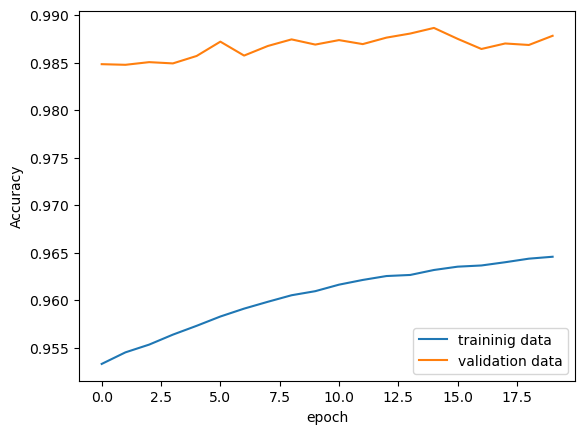

In [45]:
import matplotlib.pyplot as plt
plt.plot(Model_check.history['accuracy'])
plt.plot(Model_check.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['traininig data','validation data'], loc = 'lower right')
plt.show()